**Machine Learning Classification models with the Titanic Dataset for 17 classifiers from three ML libraries**

Import modules and libraries 

In [3]:
import numpy as np
import pandas as pd
import pickle
import os
import shutil

import tensorflow.keras as keras

import matplotlib.pyplot as plt
import seaborn as sns

import datasets
import eval_methods
import sklearn_models
import pyspark_models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

seed=0

from pyspark import SparkContext
try:
    sc = SparkContext().getOrCreate()
except:
    pass

2022-11-05 14:17:24.208200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-05 14:17:24.208218: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


* Get titanic data for pyspark and scikit-learn
* Perform train test split 

In [4]:
x_train, x_test, y_train, y_test = datasets.get_sklearn_titanic()
train, test = datasets.get_pyspark_titanic(sc)

* Build baseline models(default parameters) 

In [5]:
sklearn_classifiers = [
    sklearn_models.LinearSVC(random_state=seed),
    sklearn_models.LogisticRegression(random_state=seed),
    sklearn_models.DecisionTreeClassifier(random_state=seed),
    sklearn_models.RandomForestClassifier(random_state=seed),
    sklearn_models.GaussianNB(),
    sklearn_models.GradientBoostingClassifier(random_state=seed),
    sklearn_models.MLPClassifier(random_state=seed),
    sklearn_models.OneVsRestClassifier(sklearn_models.LinearSVC())
]
pyspark_classifiers = [
    pyspark_models.LinearSVC(labelCol="label"),
    pyspark_models.LogisticRegression(labelCol="label"),
    pyspark_models.DecisionTreeClassifier(labelCol="label", seed=seed),
    pyspark_models.RandomForestClassifier(labelCol = 'label', seed=seed),
    pyspark_models.NaiveBayes(labelCol = 'label', modelType="gaussian"),
    pyspark_models.GBTClassifier(labelCol = 'label', seed=seed),
    pyspark_models.MultilayerPerceptronClassifier(labelCol = 'label', seed=seed, layers=[len(test.toPandas()["features"][0]),100,]),
    pyspark_models.OneVsRest(labelCol = 'label', classifier=pyspark_models.LinearSVC())
]

* Define performance metrics
   * Recall, precions,acuracy, and RoC
* Train the models on the training datasets
* Evalute the models on the test data 
* Scikit-learn Models 
* Keras Network model 

CPU times: user 3.34 s, sys: 1.39 s, total: 4.72 s
Wall time: 2.22 s


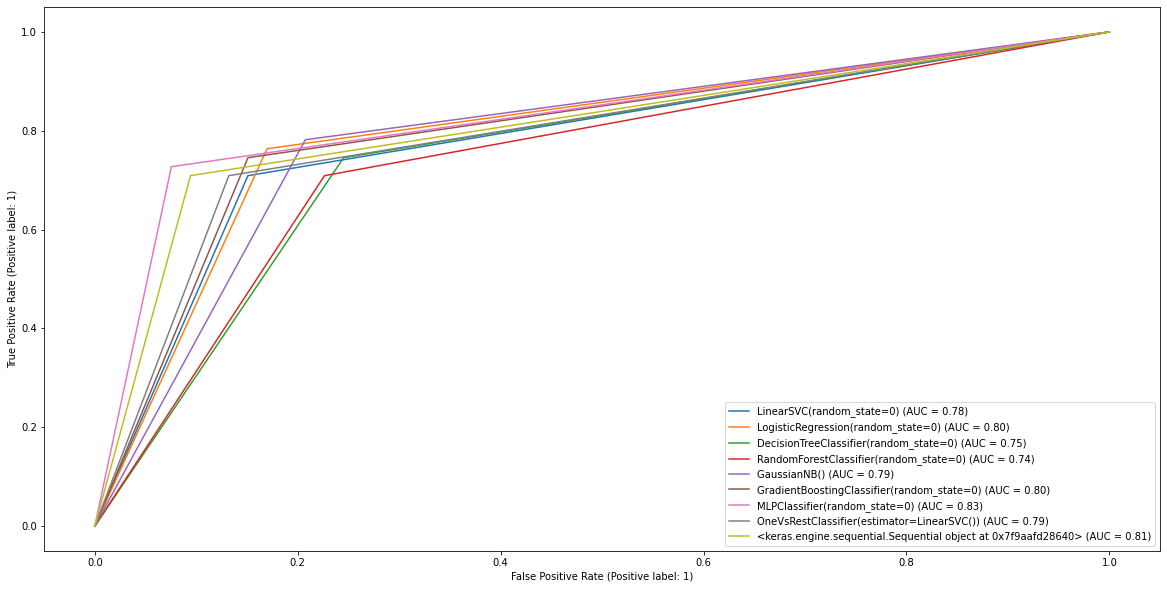

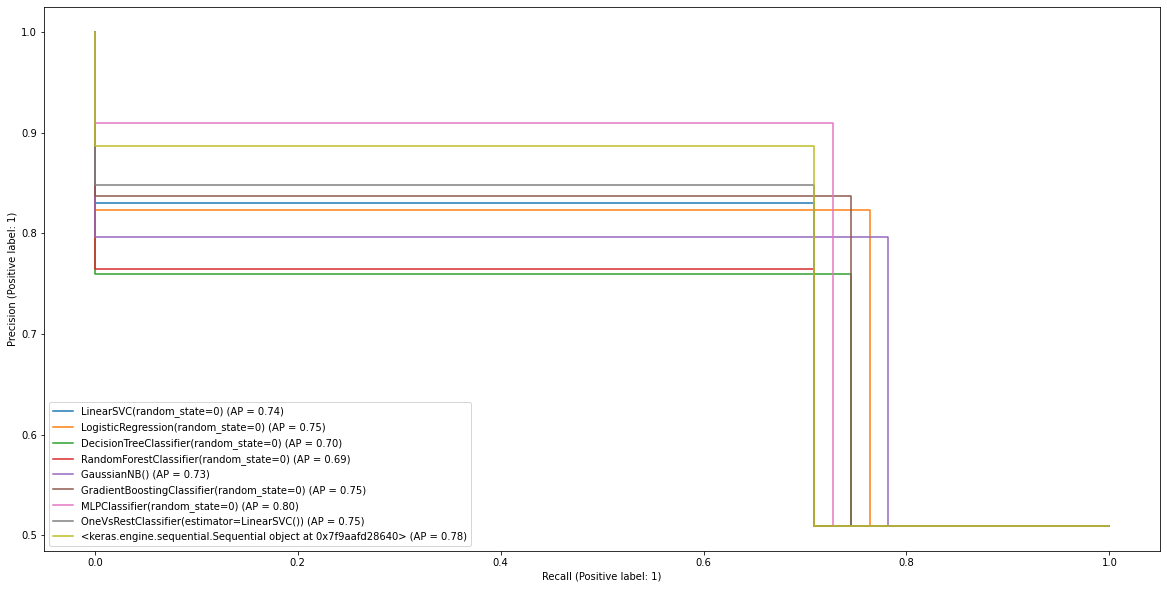

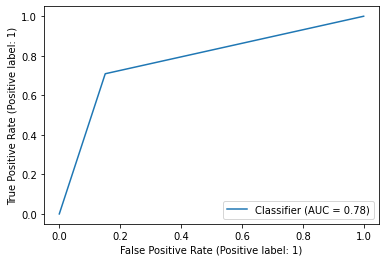

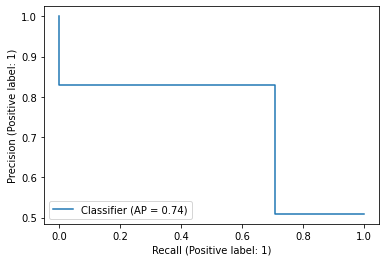

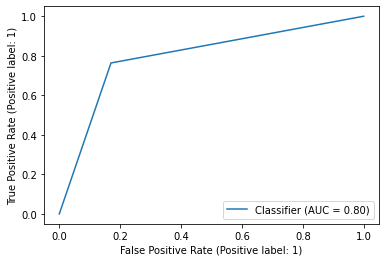

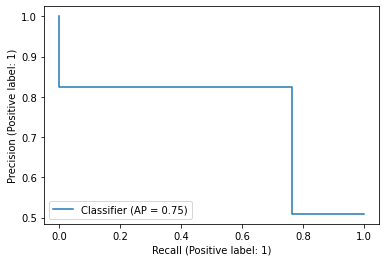

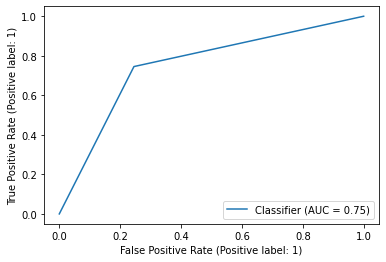

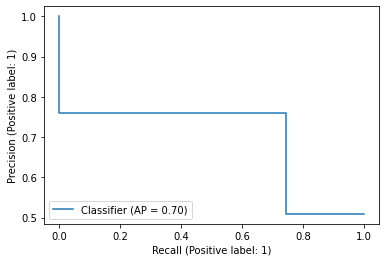

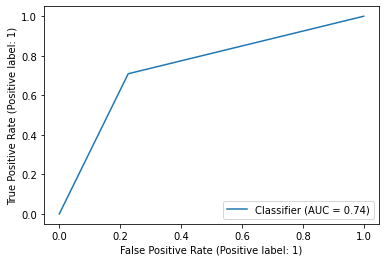

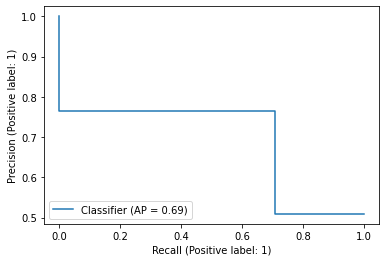

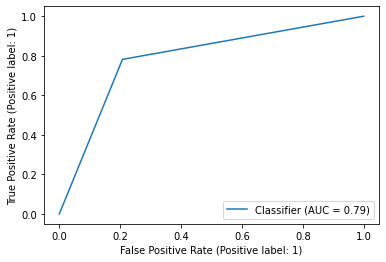

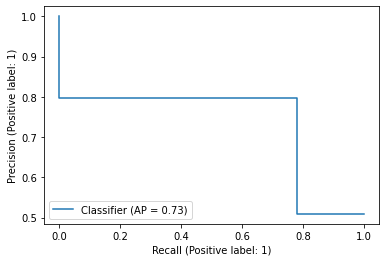

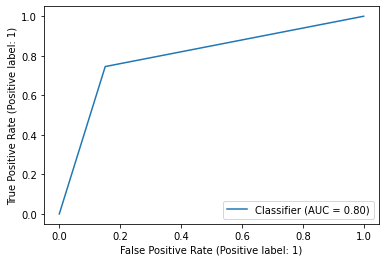

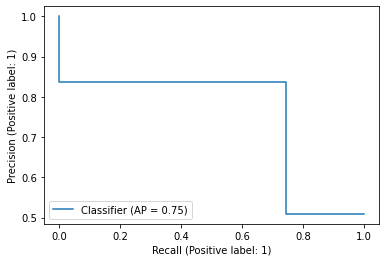

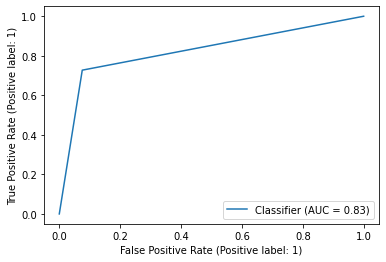

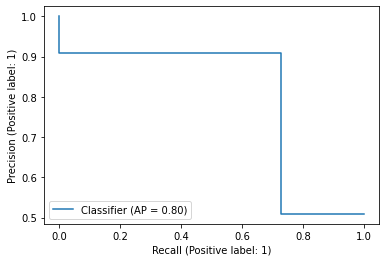

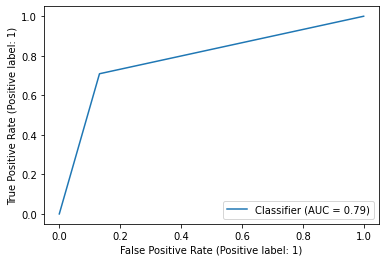

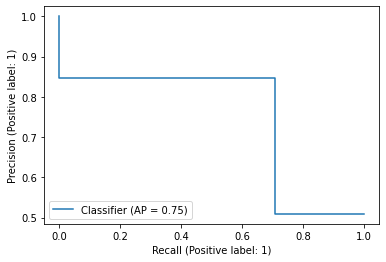

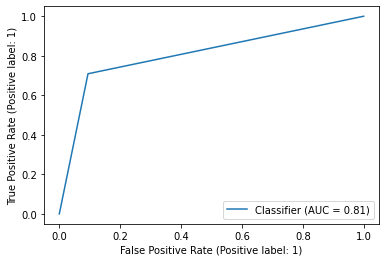

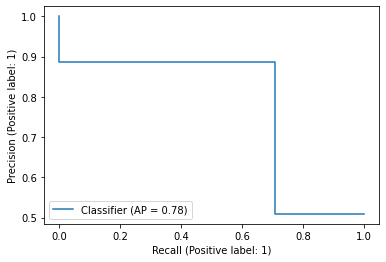

In [9]:
%%time 
# Scikit-learn model

sklearn_accuracy = []
sklearn_confusion = []
sklearn_roc = []
sklearn_precision = []
sklearn_recall = []
_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
for clf in sklearn_classifiers:
    clf.fit(x_train, y_train)
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, clf.predict(x_test), ax, bx)
    sklearn_accuracy.append(accuracy)
    sklearn_confusion.append(confusion)
    sklearn_roc.append(roc)
    sklearn_precision.append(precision)
    sklearn_recall.append(recall)

# Keras network model 

clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0)
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
sklearn_accuracy.append(accuracy)
sklearn_confusion.append(confusion)
sklearn_roc.append(roc)
sklearn_precision.append(precision)
sklearn_recall.append(recall)

* Define Performance metrics
  * Accuracy, Precison, Recall, and RoC 
* Train and evaluate the various models 
* PySpark Models 
* Keras Network model 

22/11/05 14:18:57 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/05 14:18:57 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/11/05 14:19:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/05 14:19:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


CPU times: user 3.27 s, sys: 489 ms, total: 3.76 s
Wall time: 1min 20s


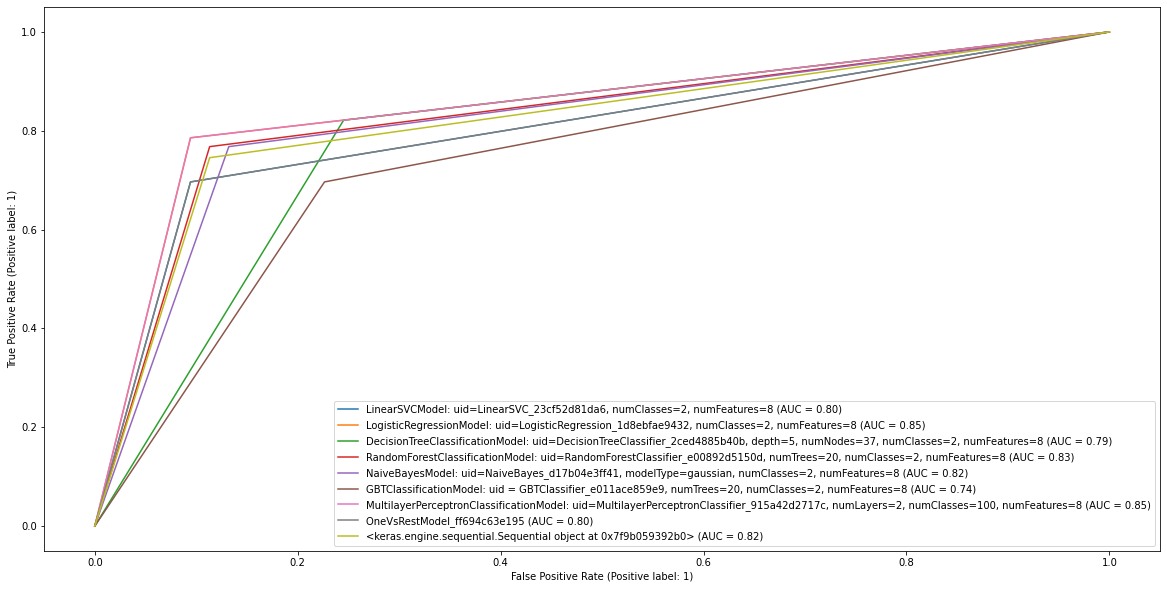

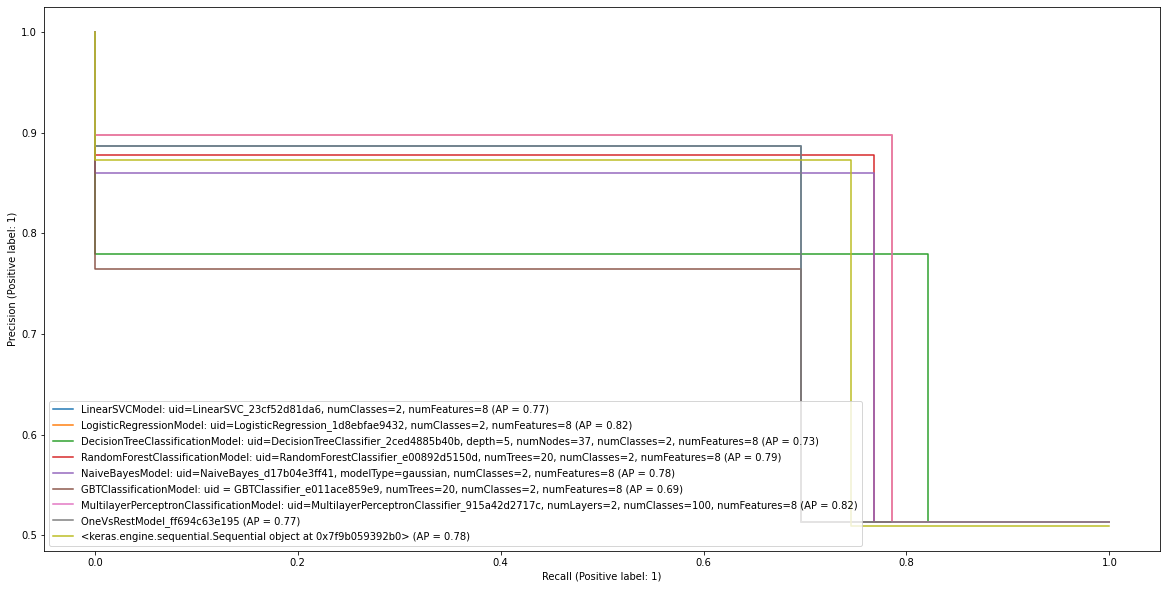

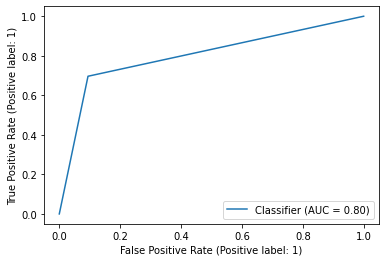

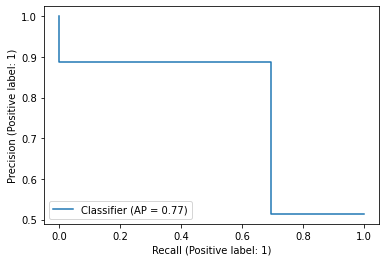

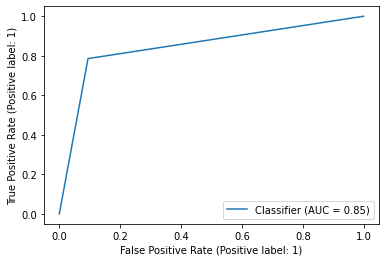

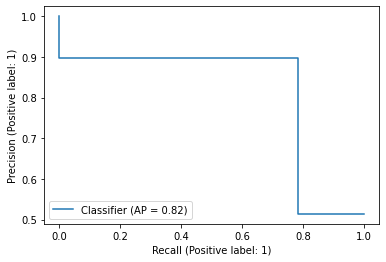

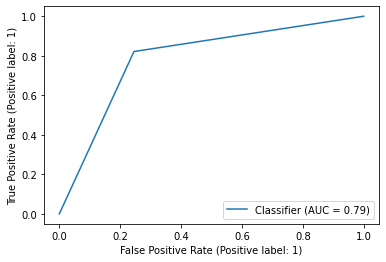

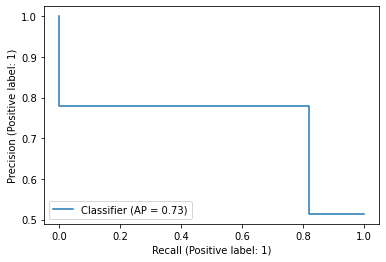

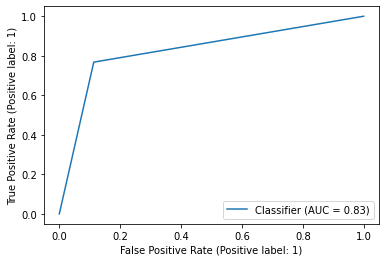

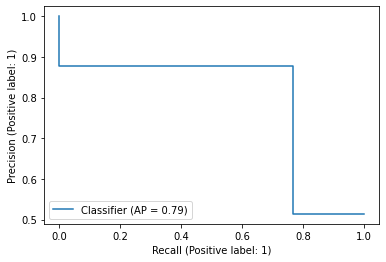

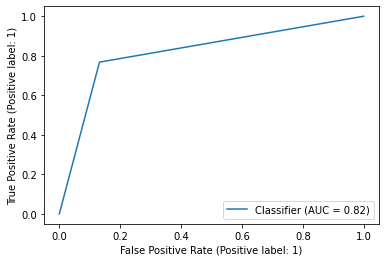

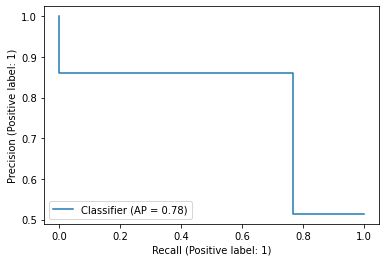

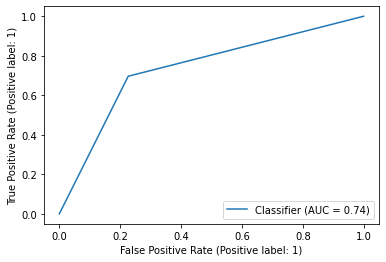

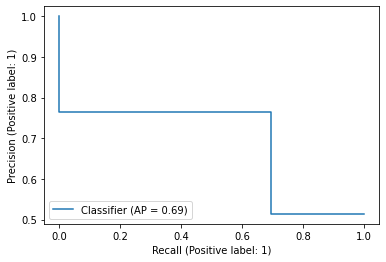

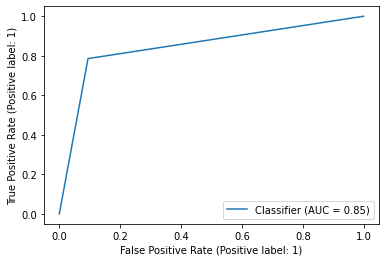

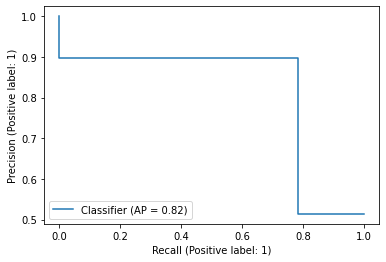

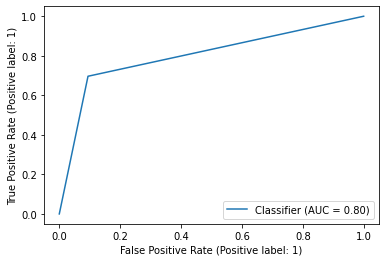

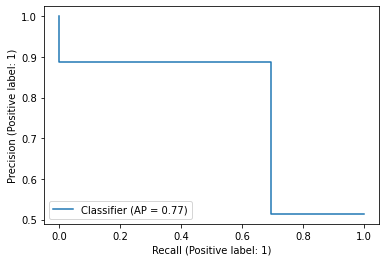

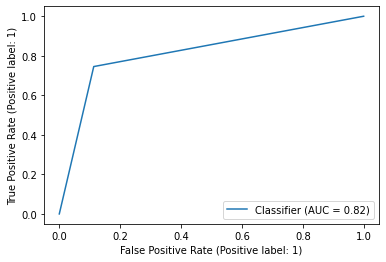

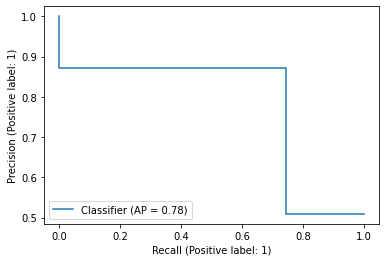

In [10]:
%%time
# PySpark models
pyspark_accuracy = []
pyspark_confusion = []
pyspark_roc = []
pyspark_precision = []
pyspark_recall = []
_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
for clf in pyspark_classifiers:
    clf = clf.fit(train)
    real = np.array([1 if "1" in str(x) else 0 for x in clf.transform(test).select("label").collect()])
    pred = np.array([1 if "1" in str(x) else 0 for x in clf.transform(test).select("prediction").collect()])
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, real, pred, ax, bx)
    pyspark_accuracy.append(accuracy)
    pyspark_confusion.append(confusion)
    pyspark_roc.append(roc)
    pyspark_precision.append(precision)
    pyspark_recall.append(recall)
# Keras Network Model   
clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0)
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
pyspark_accuracy.append(accuracy)
pyspark_confusion.append(confusion)
pyspark_roc.append(roc)
pyspark_precision.append(precision)
pyspark_recall.append(recall)

* 17 models performacne comparison 
* Accuracy
* Recall
* Precision
* Recall 
* **Note: The accuracy, recall, Precison and RoC values are higher compared to the Diabetes models**
* Average Accuracy is close to 80%
* Except for **Gradient Boosting** classifier,  the accuracy of Pyspark Classifier is higher compared to the corresponding classifiers in sckit-learn
* The value of the receall, accuracy, precision, and RoC is almost similar. 
   * This could be due to the data processing technique we employed such as class imbalance, missing value imputing technique ,etc

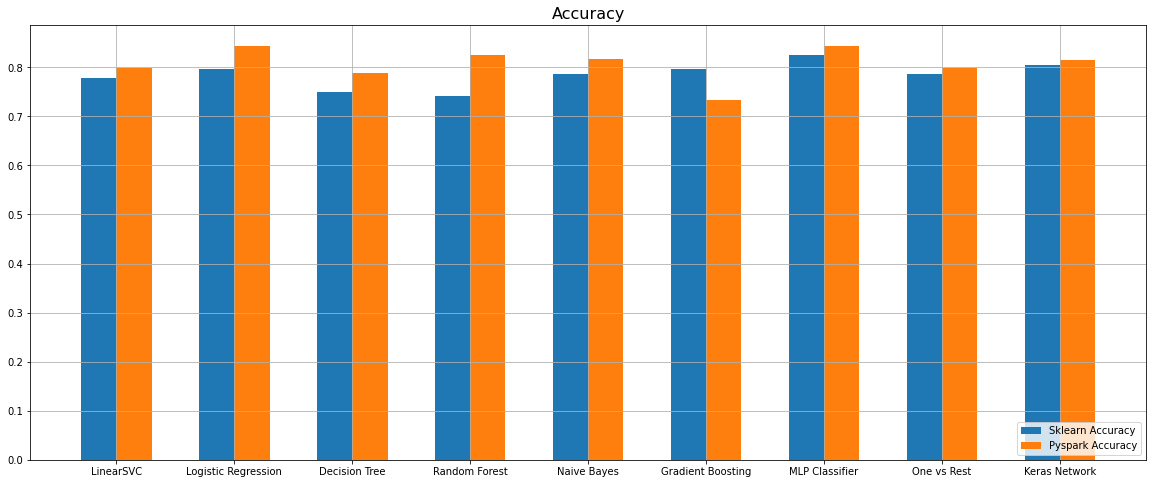

In [14]:
eval_methods.plot(sklearn_accuracy, pyspark_accuracy, "Accuracy")

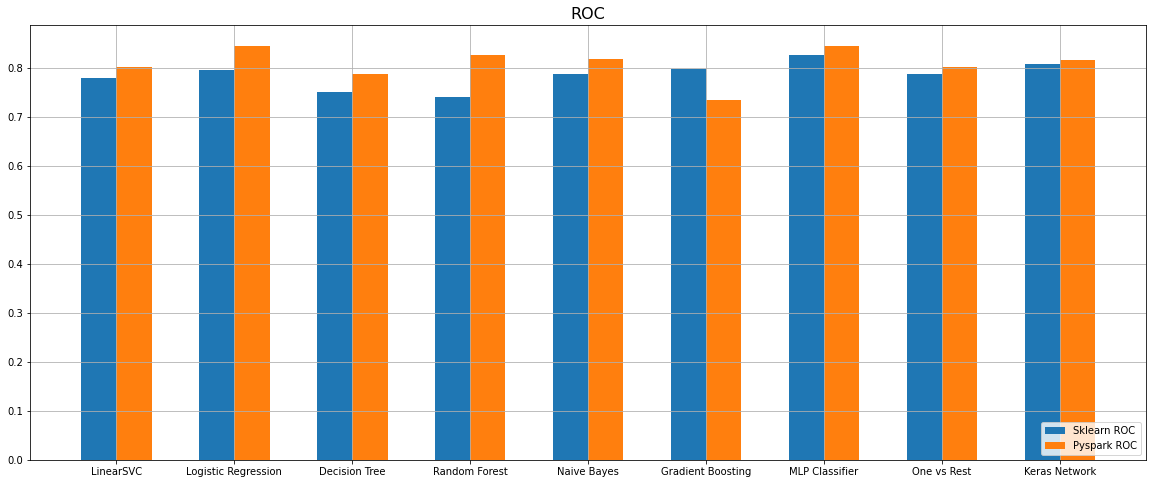

In [15]:
eval_methods.plot(sklearn_roc, pyspark_roc, "ROC")

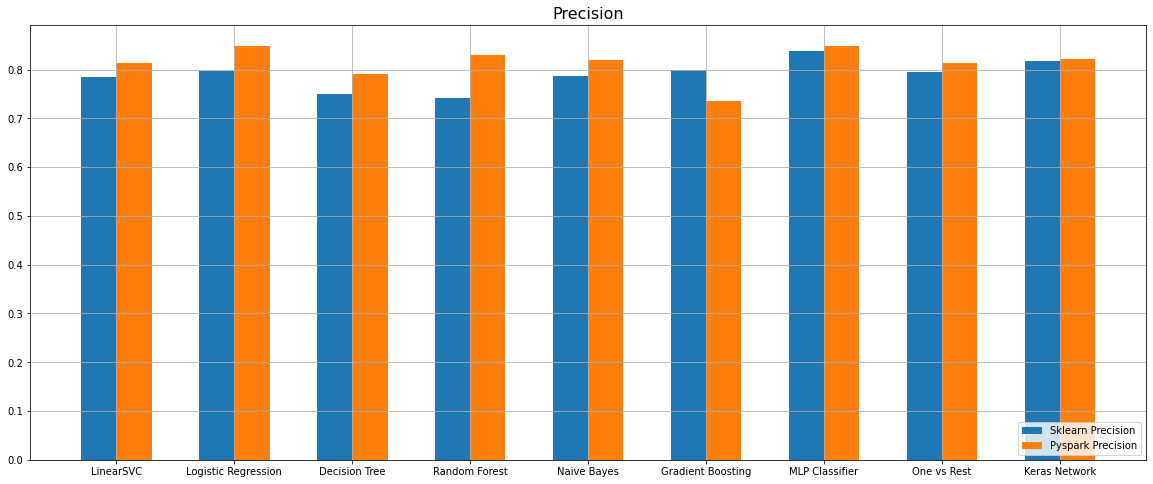

In [16]:
eval_methods.plot(sklearn_precision, pyspark_precision, "Precision")

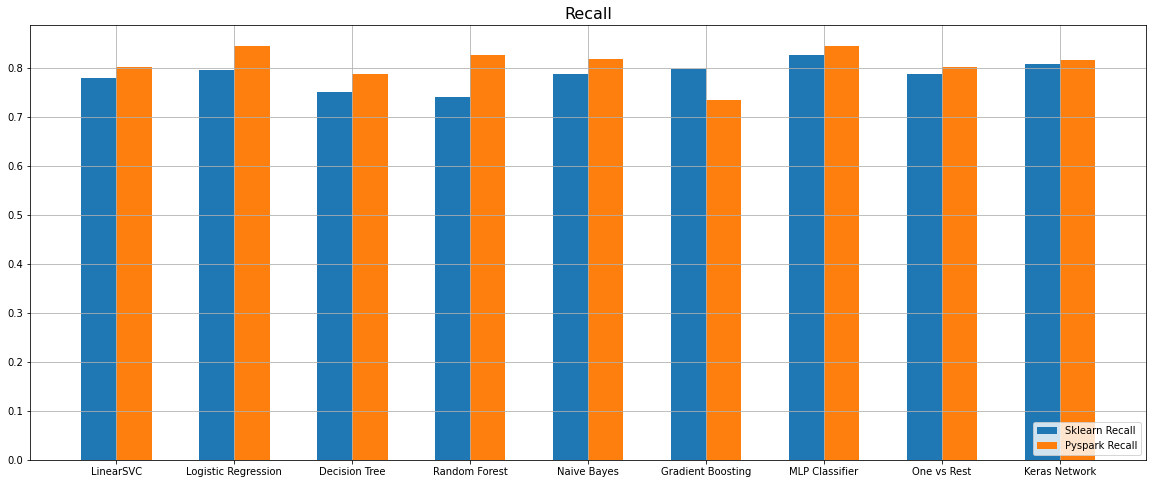

In [17]:
eval_methods.plot(sklearn_recall, pyspark_recall, "Recall")

* Hyperparameter tuning 
* Cross validation

Hyperparameters for the Scikit-learn Classifiers

In [13]:
grid = { 
    "LinearSVC": {
        "max_iter": [10, 50, 100, 500],
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "C": [0.1, 0.01, 0.001, 0.0001],
        "fit_intercept": [True, False]},
    "LogisticRegression": {
        "max_iter": [10, 50, 100, 500],
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "C": [0.1, 0.01, 0.001, 0.0001],
        "fit_intercept": [True, False]},
    "DecisionTreeClassifier": {
        "max_depth": [2, 5, 10, 20],
        "criterion": ["gini", "entropy"]},
    "RandomForestClassifier": {
        "bootstrap": [True, False],
        "max_depth": [2, 5, 10, 20],
        "criterion": ["gini", "entropy"],
        "n_estimators": [5, 10, 50, 100]},
    "GaussianNB": {
        "var_smoothing": [1e-07, 1e-08, 1e-09, 1e-10]},
    "GradientBoostingClassifier": {
        "max_features": ["auto", "sqrt", "log2"],
        "max_depth": [2, 5, 10, 20],
        "learning_rate": [0.1, 0.01, 0.001, 0.0001]},
    "MLPClassifier": {
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "max_iter": [10, 50, 100, 500],
        "batch_size": [8, 32, 128, 512]},
    "OneVsRestClassifier": {
        "n_jobs": [1, 3, 5, 7, 10]}}

Hyperparameters for the PySpark Classifiers

In [15]:
para = { 
    "LinearSVC": {
        "max_iter": ["maxIter"],
        "tol": ["tol"],
        "C": ["regParam"],
        "fit_intercept": ["fitIntercept"]},
    "LogisticRegression": {
        "max_iter": ["maxIter"],
        "tol": ["tol"],
        "C": ["regParam"],
        "fit_intercept": ["fitIntercept"]},
    "DecisionTreeClassifier": {
        "max_depth": ["maxDepth"],
        "criterion": ["impurity"]},
    "RandomForestClassifier": {
        "bootstrap": ["bootstrap"],
        "max_depth": ["maxDepth"],
        "criterion": ["impurity"],
        "n_estimators": ["numTrees"]},
    "GaussianNB": {
        "var_smoothing": ["smoothing"]},
    "GradientBoostingClassifier": {
        "max_features": ["featureSubsetStrategy"],
        "max_depth": ["maxDepth"],
        "learning_rate": ["stepSize"]},
    "MLPClassifier": {
        "tol": ["tol"],
        "max_iter": ["maxIter"],
        "batch_size": ["blockSize"]},
    "OneVsRestClassifier": {
        "n_jobs": ["parallelism"]}}

* Train , evaluate and save opitimized models 
* LinearSVC, DecisionTrees, RandomForestOneVsrest, and Logistic regression have shortest training time 
* GradientBoostingClassifier takes a bit longer
* MLP has the longest training time
* Compare and Contrast the performance 

LinearSVC {'C': 0.1, 'fit_intercept': False, 'max_iter': 10, 'tol': 0.01}
LogisticRegression {'C': 0.1, 'fit_intercept': True, 'max_iter': 10, 'tol': 0.01}
DecisionTreeClassifier {'criterion': 'gini', 'max_depth': 10}
RandomForestClassifier {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}
GaussianNB {'var_smoothing': 1e-07}
GradientBoostingClassifier {'learning_rate': 0.01, 'max_depth': 2, 'max_features': 'auto'}
MLPClassifier {'batch_size': 8, 'max_iter': 50, 'tol': 0.01}
OneVsRestClassifier {'n_jobs': 1}


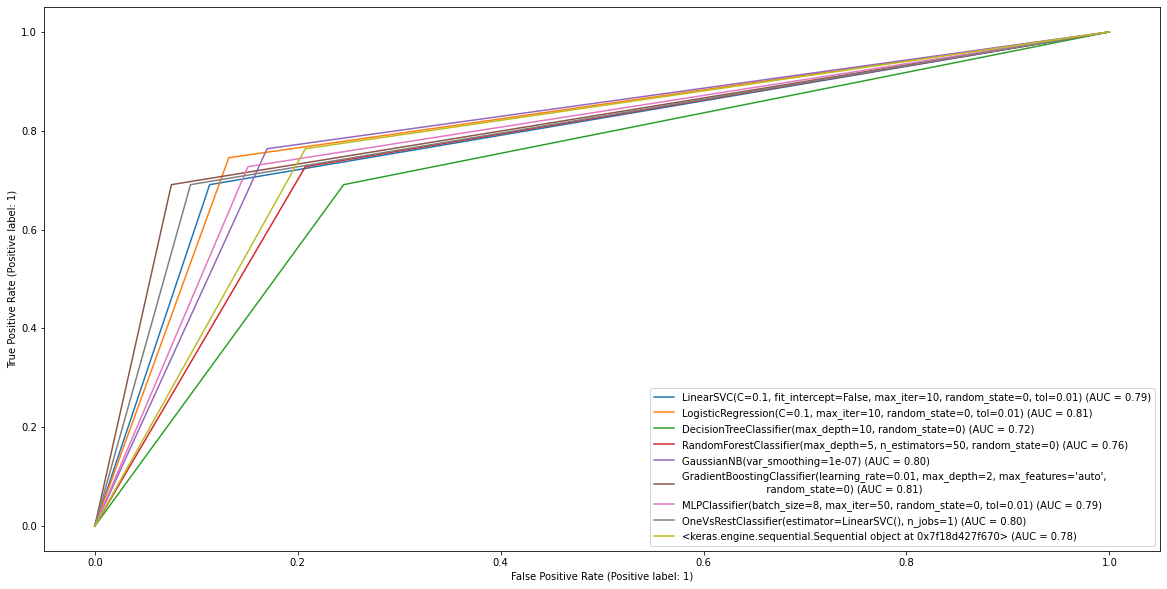

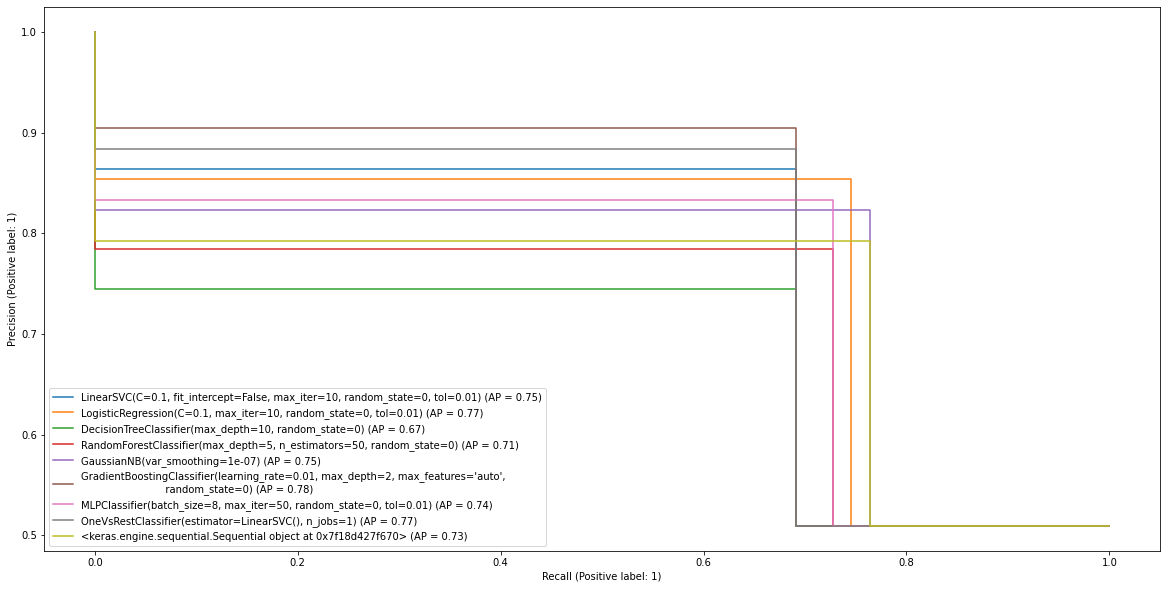

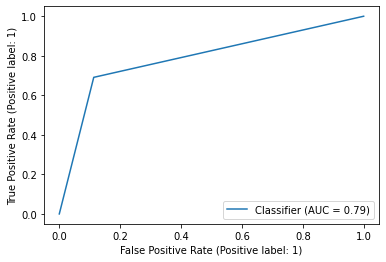

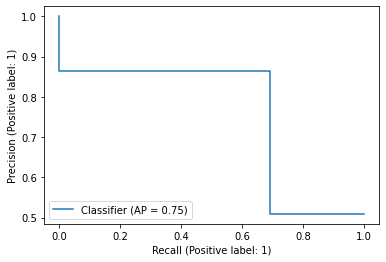

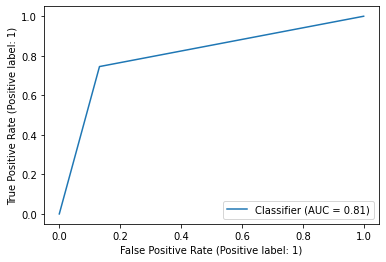

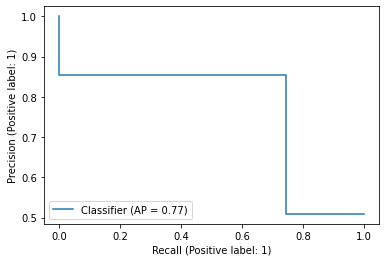

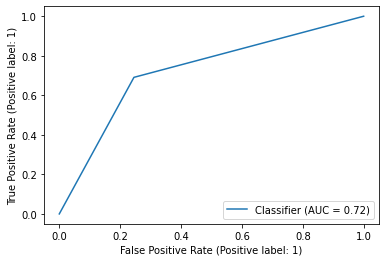

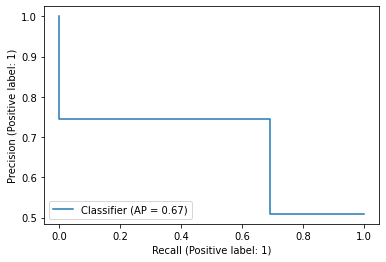

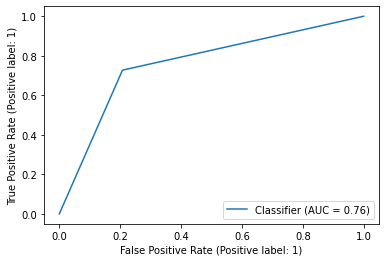

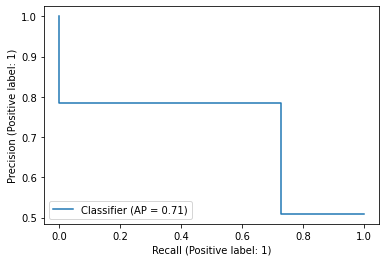

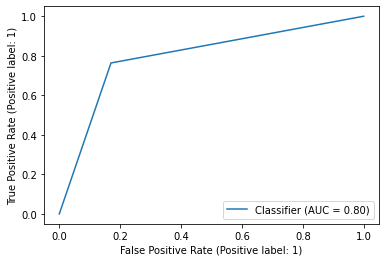

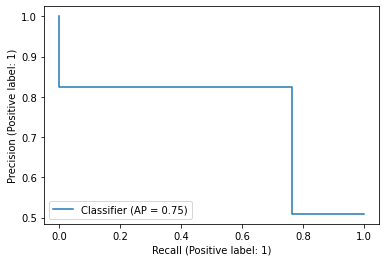

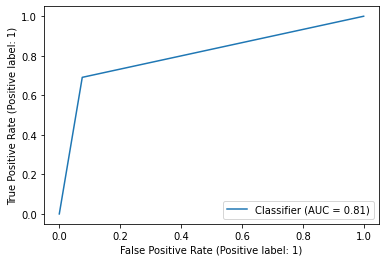

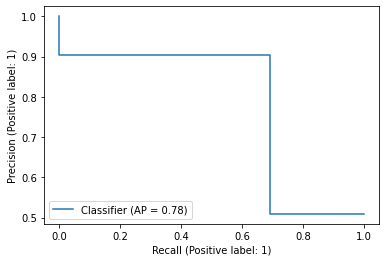

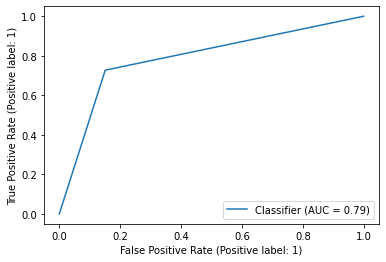

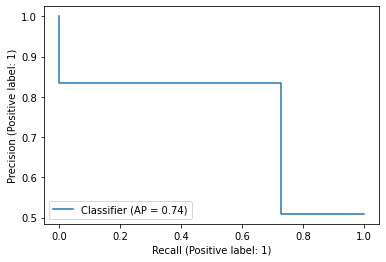

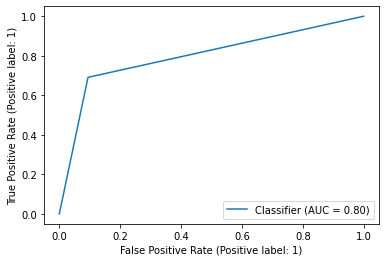

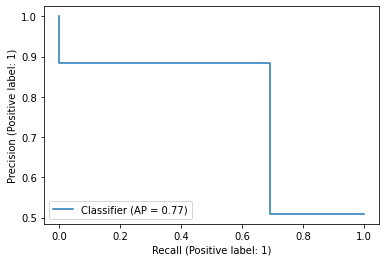

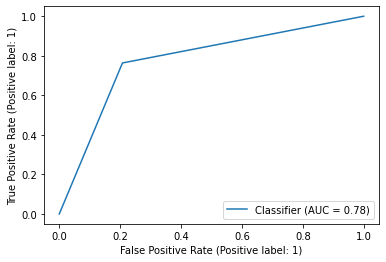

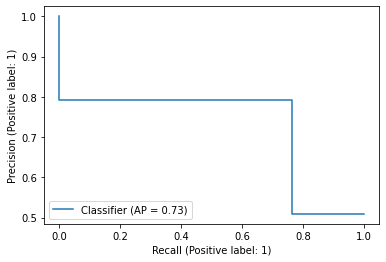

In [16]:
sklearn_accuracy = []
sklearn_confusion = []
sklearn_roc = []
sklearn_precision = []
sklearn_recall = []

_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
for clf in sklearn_classifiers:
    rf_cv = GridSearchCV(estimator=clf, param_grid=grid[str(clf)[:str(clf).find("(")]], cv= 5)
    rf_cv.fit(x_train, y_train)
    clf = clf.set_params(**rf_cv.best_params_)
    clf.fit(x_train, y_train)
    if not os.path.exists("./models/titanic/sklearn/"):
        os.makedirs("./models/titanic/sklearn/")
    pickle.dump(clf, open("./models/titanic/sklearn/"+str(clf)[:str(clf).find("(")]+".sav", 'wb'))
    for i, v in rf_cv.best_params_.items():
        para[str(clf)[:str(clf).find("(")]][i].append(v)
    print(str(clf)[:str(clf).find("(")], rf_cv.best_params_)
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, clf.predict(x_test), ax, bx)
    sklearn_accuracy.append(accuracy)
    sklearn_confusion.append(confusion)
    sklearn_roc.append(roc)
    sklearn_precision.append(precision)
    sklearn_recall.append(recall)
    
clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0, epochs=5)
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
sklearn_accuracy.append(accuracy)
sklearn_confusion.append(confusion)
sklearn_roc.append(roc)
sklearn_precision.append(precision)
sklearn_recall.append(recall)


Assigning the parameter keys to Pyspark Classifiers 

In [18]:
grid = {}
for i in para.keys():
    if i == "GaussianNB":
        grid["NaiveBayes"] = {}
        for j in para[i].values():
            grid["NaiveBayes"][j[0]] = j[1]
    elif i == "GradientBoostingClassifier":
        grid["GBTClassifier"] = {}
        for j in para[i].values():
            grid["GBTClassifier"][j[0]] = j[1]
    elif i == "MLPClassifier":
        grid["MultilayerPerceptronClassifier"] = {}
        for j in para[i].values():
            grid["MultilayerPerceptronClassifier"][j[0]] = j[1]
    elif i == "OneVsRestClassifier":
        grid["OneVsRest"] = {}
        for j in para[i].values():
            grid["OneVsRest"][j[0]] = j[1]
    else:
        grid[i] = {}
        for j in para[i].values():
            grid[i][j[0]] = j[1]

* PySpark training is pretty quick compared to corresponding scikit-learn models
* Training all optimized models in **PySpark** is equivalent to training a single optimized **LinearSVC** model in Scikit-Learn 

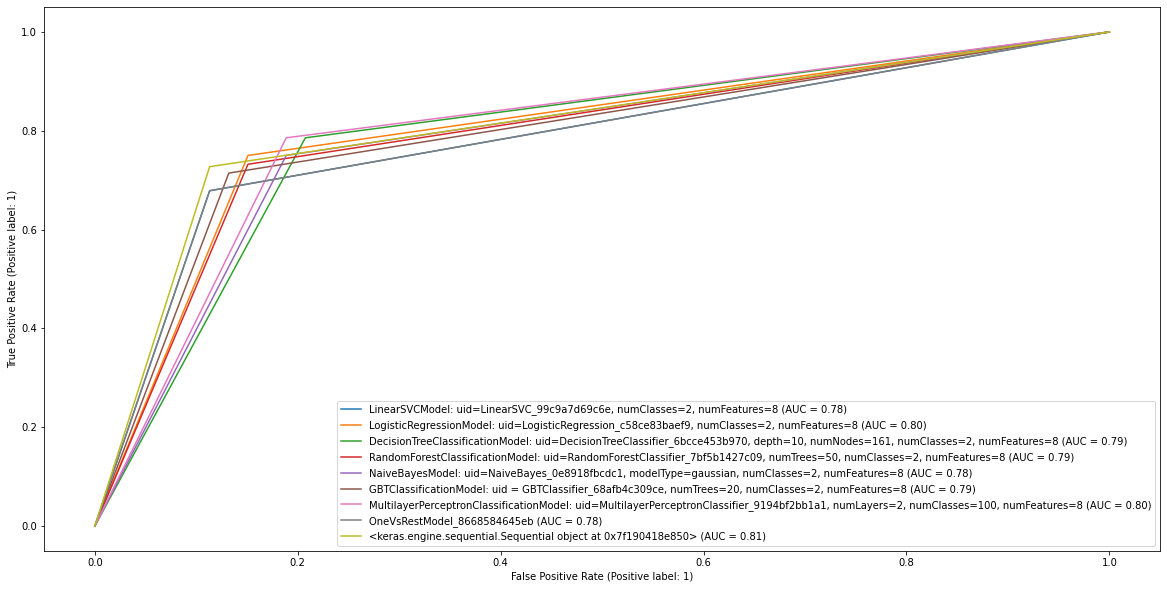

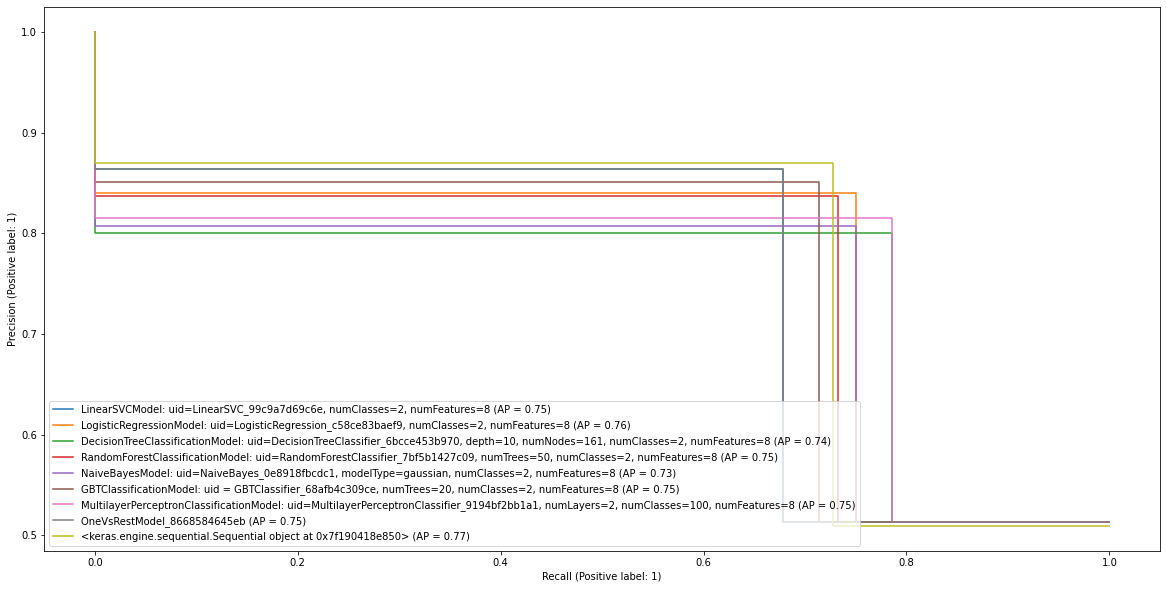

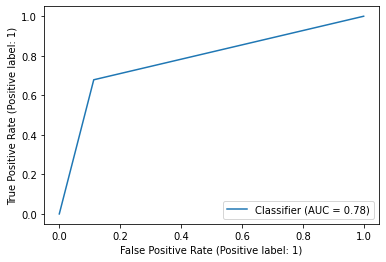

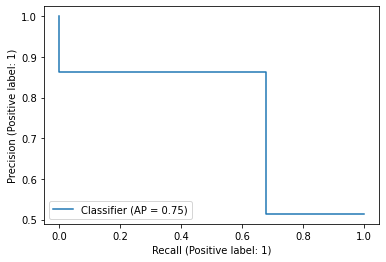

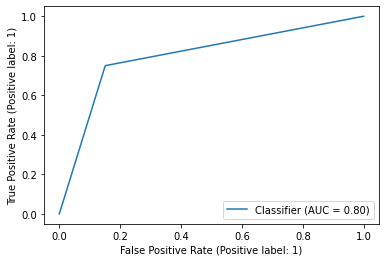

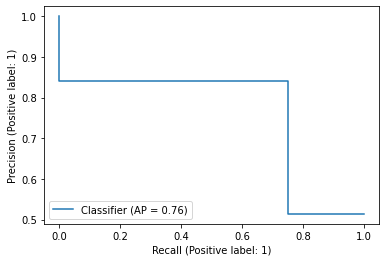

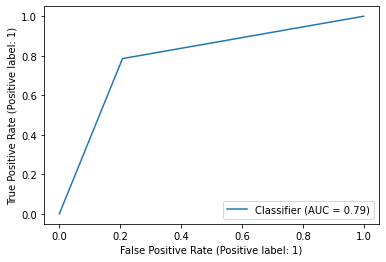

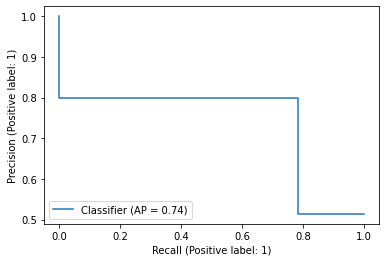

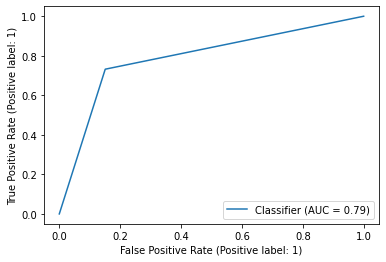

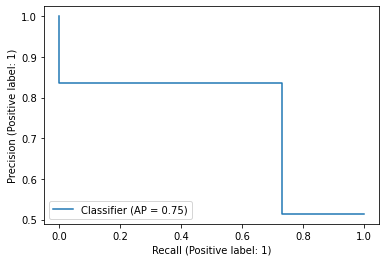

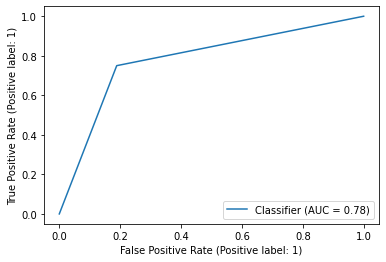

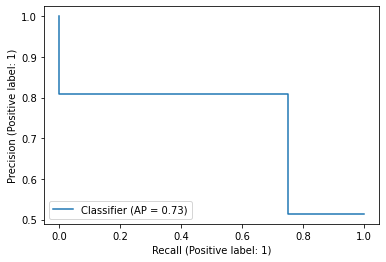

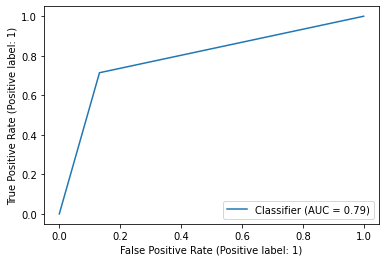

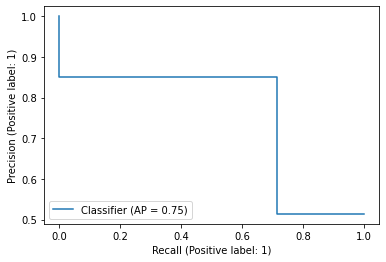

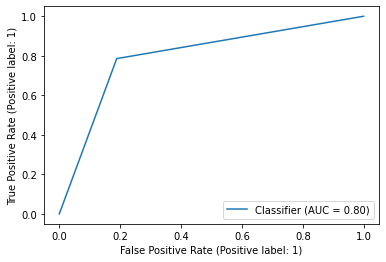

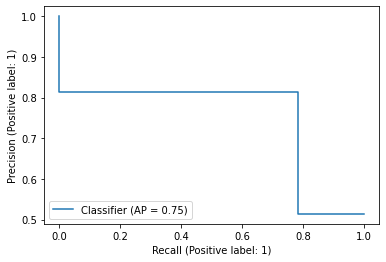

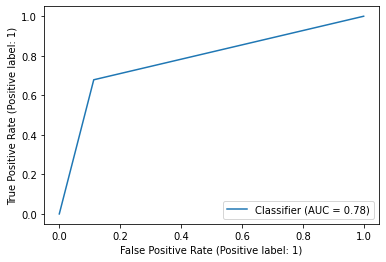

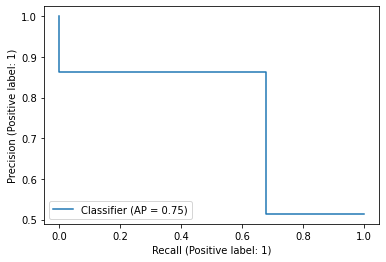

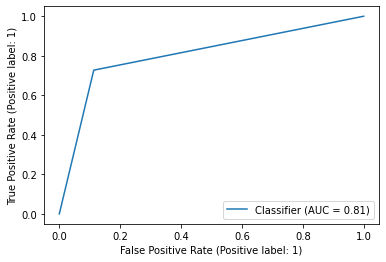

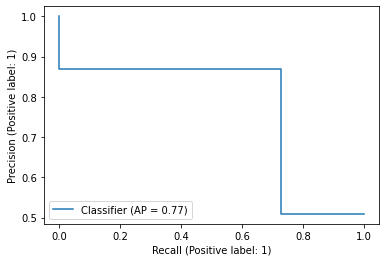

In [19]:
pyspark_accuracy = []
pyspark_confusion = []
pyspark_roc = []
pyspark_precision = []
pyspark_recall = []
_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
if os.path.exists("./models/titanic/pyspark/"):
    shutil.rmtree("./models/titanic/pyspark/", ignore_errors=True)
for clf in pyspark_classifiers:
    clf = clf.setParams(**grid[str(clf)[:str(clf).find("_")]])
    clf = clf.fit(train)
    if not os.path.exists("./models/titanic/pyspark/"):
        os.makedirs("./models/titanic/pyspark/")
    clf.save("./models/titanic/pyspark/"+str(clf)[:str(clf).find("_")])
    real = np.array([1 if "1" in str(x) else 0 for x in clf.transform(test).select("label").collect()])
    pred = np.array([1 if "1" in str(x) else 0 for x in clf.transform(test).select("prediction").collect()])
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, real, pred, ax, bx)
    pyspark_accuracy.append(accuracy)
    pyspark_confusion.append(confusion)
    pyspark_roc.append(roc)
    pyspark_precision.append(precision)
    pyspark_recall.append(recall)
    
clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0, epochs=5)
clf.save("./models/titanic/keras.h5")
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
pyspark_accuracy.append(accuracy)
pyspark_confusion.append(confusion)
pyspark_roc.append(roc)
pyspark_precision.append(precision)
pyspark_recall.append(recall)

* Compare and visualize the optimized models using accuracy, precision,  recall, and Roc   

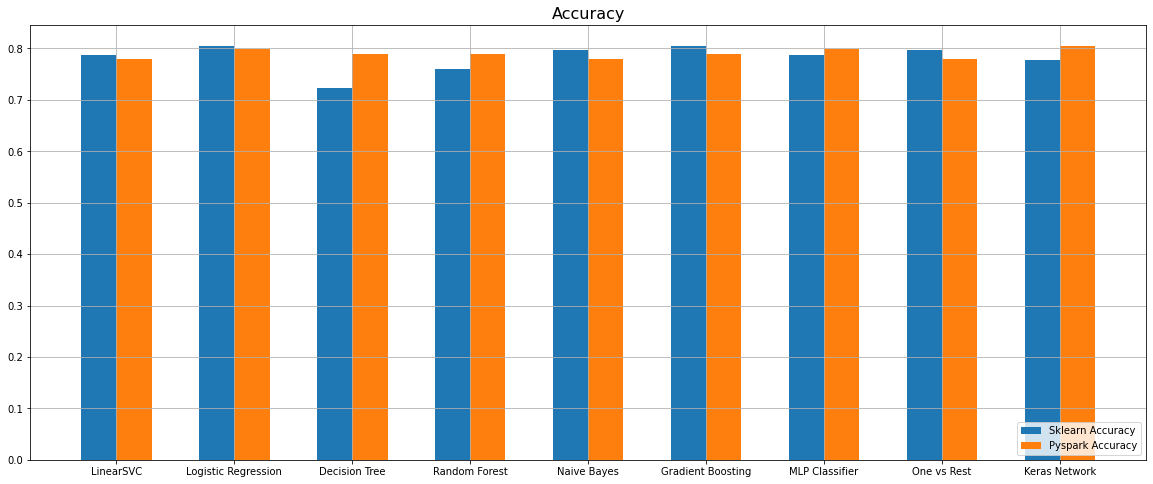

In [20]:
eval_methods.plot(sklearn_accuracy, pyspark_accuracy, "Accuracy")

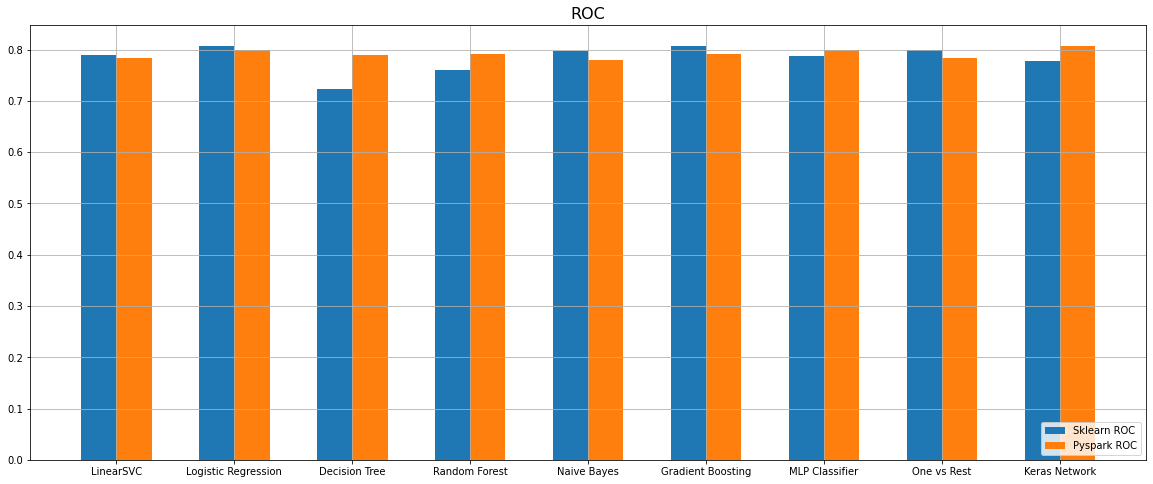

In [21]:
eval_methods.plot(sklearn_roc, pyspark_roc, "ROC")

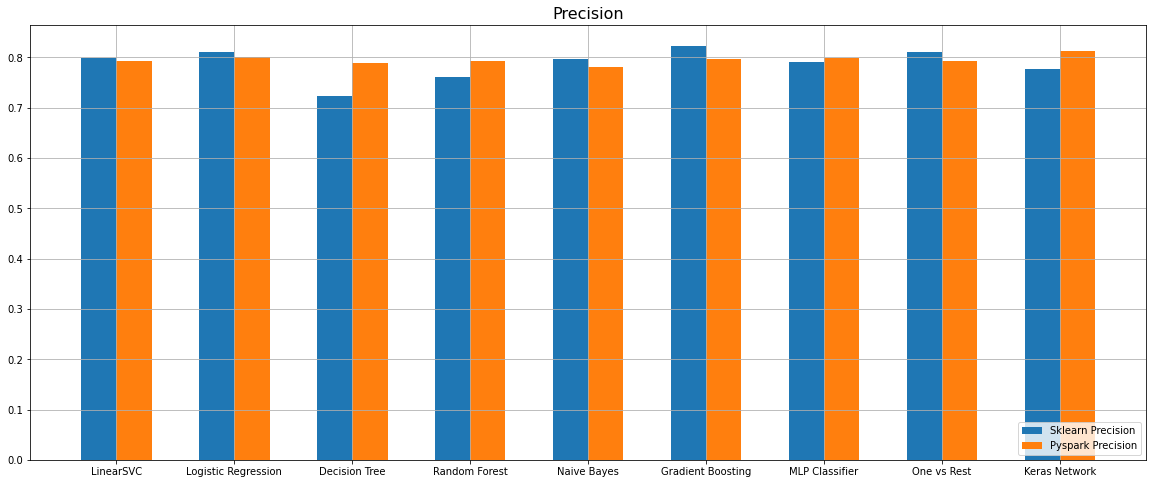

In [22]:
eval_methods.plot(sklearn_precision, pyspark_precision, "Precision")

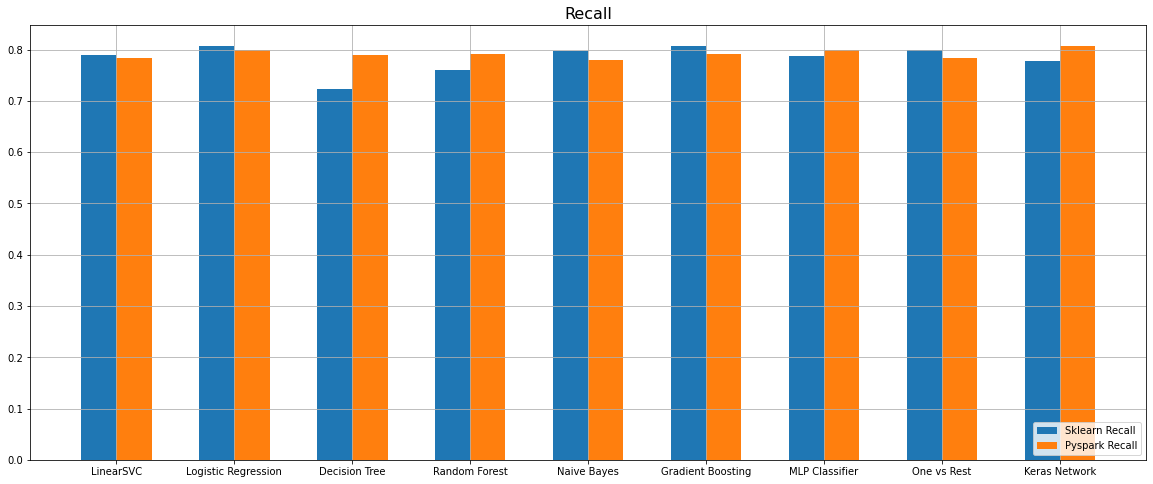

In [23]:
eval_methods.plot(sklearn_recall, pyspark_recall, "Recall")

 =============End=============